In [3]:
import sys
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
import tensorflow as tf
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn


In [4]:
tf.__version__


'1.7.0'

In [5]:
df_0403_m= pd.read_csv('data/0403_samsung_min_U.csv',header=0)
print(df_0403_m.head())


                         date  a stock   time    price  price_ch  vol_ch   vol
0  2018-04-03 08:52:27.877289  예  삼성전자  85232  2400000    -27000      62  2666
1  2018-04-03 08:53:26.995767  예  삼성전자  85332  2400000    -27000     -17  2649
2  2018-04-03 08:54:32.248435  예  삼성전자  85432  2400000    -27000     -21  2628
3  2018-04-03 08:55:30.998705  예  삼성전자  85532  2391000    -36000    1721  4349
4  2018-04-03 08:56:32.936148  예  삼성전자  85632  2395000    -32000    -149  4200


In [7]:
sam_0403_m = df_0403_m.query('stock=="삼성전자"')
print(sam_0403_m.head())

                         date  a stock   time    price  price_ch  vol_ch   vol
0  2018-04-03 08:52:27.877289  예  삼성전자  85232  2400000    -27000      62  2666
1  2018-04-03 08:53:26.995767  예  삼성전자  85332  2400000    -27000     -17  2649
2  2018-04-03 08:54:32.248435  예  삼성전자  85432  2400000    -27000     -21  2628
3  2018-04-03 08:55:30.998705  예  삼성전자  85532  2391000    -36000    1721  4349
4  2018-04-03 08:56:32.936148  예  삼성전자  85632  2395000    -32000    -149  4200


In [8]:
sort_0403_m=sam_0403_m.sort_values(by=['date','price'])


In [17]:
partcol_0403_m =sam_0403_m[['date','price','vol','vol_ch']]
print(partcol_0403_m.head())

                         date    price   vol  vol_ch
0  2018-04-03 08:52:27.877289  2400000  2666      62
1  2018-04-03 08:53:26.995767  2400000  2649     -17
2  2018-04-03 08:54:32.248435  2400000  2628     -21
3  2018-04-03 08:55:30.998705  2391000  4349    1721
4  2018-04-03 08:56:32.936148  2395000  4200    -149


In [18]:
# query
partcol_0403_m_09 = partcol_0403_m.query('date>="2018-04-03 09:00:00" & date<="2018-04-03 15:21:00"')
print(partcol_0403_m_09.head())

                          date    price    vol  vol_ch
8   2018-04-03 09:00:32.817893  2393000   7354    8039
9   2018-04-03 09:01:31.570204  2405000  10395    3041
10   2018-04-03 09:02:32.58903  2398000  12873    2478
11  2018-04-03 09:03:33.060493  2404000  13874    1001
12  2018-04-03 09:04:32.957566  2400000  16300    2426


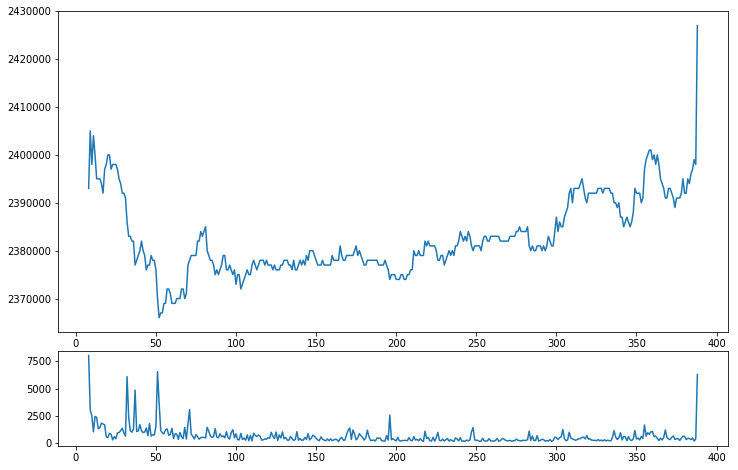

In [ ]:
#plot
partcol_0403_m_09.plot(x='date',y='price',title = 'samsung')
plt.show()


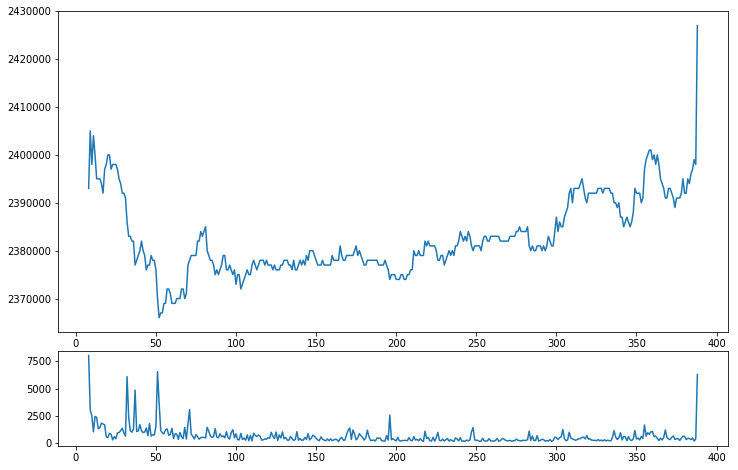

In [27]:
fig = plt.figure(figsize=(12, 8))

top_axes = plt.subplot2grid((4,4), (0,0), rowspan=3, colspan=4)
bottom_axes = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom_axes.get_yaxis().get_major_formatter().set_scientific(False)

top_axes.plot(partcol_0403_m_09.index, partcol_0403_m_09['price'], label='')
bottom_axes.plot(partcol_0403_m_09.index, partcol_0403_m_09['vol_ch'])


In [26]:

print(len(partcol_0403_m_09))
ts =pd.Series(partcol_0403_m_09['price'].values, index=partcol_0403_m_09['date'])
print(ts)

381
date
2018-04-03 09:00:32.817893    2393000
2018-04-03 09:01:31.570204    2405000
2018-04-03 09:02:32.58903     2398000
2018-04-03 09:03:33.060493    2404000
2018-04-03 09:04:32.957566    2400000
2018-04-03 09:05:33.450041    2395000
2018-04-03 09:06:32.620631    2395000
2018-04-03 09:07:33.266207    2395000
2018-04-03 09:08:33.18964     2394000
2018-04-03 09:09:33.321873    2392000
2018-04-03 09:10:32.261308    2397000
2018-04-03 09:11:32.689739    2398000
2018-04-03 09:12:33.184218    2400000
2018-04-03 09:13:32.512911    2400000
2018-04-03 09:14:31.565423    2397000
2018-04-03 09:15:33.308737    2398000
2018-04-03 09:16:33.31188     2398000
2018-04-03 09:17:30.620226    2398000
2018-04-03 09:18:31.69709     2397000
2018-04-03 09:19:32.526792    2395000
2018-04-03 09:20:33.250419    2394000
2018-04-03 09:21:33.135486    2392000
2018-04-03 09:22:32.396136    2392000
2018-04-03 09:23:33.3209      2391000
2018-04-03 09:24:33.014841    2386000
2018-04-03 09:25:33.258148    2383000
201

In [12]:
TS=np.asarray(ts)

num_periods = 20
f_horizon =1   #forcast horizon 1 period 360

x_data = TS[:(len(TS)-(len(TS) % num_periods))]
x_batches = x_data.reshape(-1,20,1)

y_data = TS[1:(len(TS)-(len(TS) % num_periods))+f_horizon]
y_batches = y_data.reshape(-1,20,1)

print(len(x_batches))
print(x_batches.shape)
print(x_batches[0:2])

print(y_batches[0:1])
print(y_batches.shape)


19
(19, 20, 1)
[[[2393000]
  [2405000]
  [2398000]
  [2404000]
  [2400000]
  [2395000]
  [2395000]
  [2395000]
  [2394000]
  [2392000]
  [2397000]
  [2398000]
  [2400000]
  [2400000]
  [2397000]
  [2398000]
  [2398000]
  [2398000]
  [2397000]
  [2395000]]

 [[2394000]
  [2392000]
  [2392000]
  [2391000]
  [2386000]
  [2383000]
  [2383000]
  [2382000]
  [2382000]
  [2377000]
  [2378000]
  [2379000]
  [2380000]
  [2382000]
  [2380000]
  [2379000]
  [2376000]
  [2377000]
  [2377000]
  [2379000]]]
[[[2405000]
  [2398000]
  [2404000]
  [2400000]
  [2395000]
  [2395000]
  [2395000]
  [2394000]
  [2392000]
  [2397000]
  [2398000]
  [2400000]
  [2400000]
  [2397000]
  [2398000]
  [2398000]
  [2398000]
  [2397000]
  [2395000]
  [2394000]]]
(19, 20, 1)


In [13]:

#pull out test data

def test_data(series,forcast,num_periods):
    test_x_setup = TS[-(num_periods+forcast):]
    test_x = test_x_setup[:num_periods].reshape(-1,20,1)
    test_y = TS[-(num_periods):].reshape(-1,20,1)
    return test_x,test_y

x_test, y_test = test_data(TS,f_horizon,num_periods)
print(x_test)
print(x_test.reshape)


[[[2391000]
  [2391000]
  [2393000]
  [2393000]
  [2392000]
  [2391000]
  [2389000]
  [2391000]
  [2391000]
  [2391000]
  [2392000]
  [2395000]
  [2392000]
  [2392000]
  [2395000]
  [2394000]
  [2396000]
  [2397000]
  [2399000]
  [2398000]]]
<built-in method reshape of numpy.ndarray object at 0x000002035CD95850>


In [14]:


num_periods = 20
######################
hidden = 100
######################
input = 1
output = 1

x=tf.placeholder(tf.float32,[None, num_periods, input])
y=tf.placeholder(tf.float32,[None, num_periods, output])

#create rnn object
basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
#Rectified Linear Unit - ReLU
# can be changed to Sigmoid or Hyberbolic Tangent (Tanh)
rnn_output, states=tf.nn.dynamic_rnn(basic_cell,x, dtype=tf.float32)

######################################
learning_rate=0.01  #learning rate low
######################################

stacked_rnn_output = tf.reshape(rnn_output, [-1,hidden])
stacked_outputs = tf.layers.dense(stacked_rnn_output,output)
outputs = tf.reshape(stacked_outputs, [-1,num_periods,output])

loss = tf.reduce_sum(tf.square(outputs-y))
optimizer=tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op=optimizer.minimize(loss)

init = tf.global_variables_initializer()

##########################################
epochs = 500        #num of traing cycles
##########################################


In [15]:
with tf.Session() as sess:
    init.run()
    for ep in range(epochs):
        sess.run(training_op,feed_dict={x:x_batches,y:y_batches})
        if ep%100==0:
            mse = loss.eval(feed_dict={x:x_batches,y:y_batches})
            print(ep,'\tMSE:',mse)
    y_pred=sess.run(outputs,feed_dict={x: x_test})
    print(y_pred)




0 	MSE: 3290950200000000.0


100 	MSE: 31647023000.0


200 	MSE: 6316228600.0


300 	MSE: 4567270400.0


400 	MSE: 3588660700.0


[[[2391830. ]
  [2391237.2]
  [2393079.2]
  [2392587.8]
  [2392322.2]
  [2390997.8]
  [2393365. ]
  [2395824.8]
  [2393525.8]
  [2390556.5]
  [2390691.2]
  [2392518. ]
  [2391436. ]
  [2391407. ]
  [2393283. ]
  [2393179.2]
  [2394668.8]
  [2395757. ]
  [2397562.2]
  [2397309.8]]]


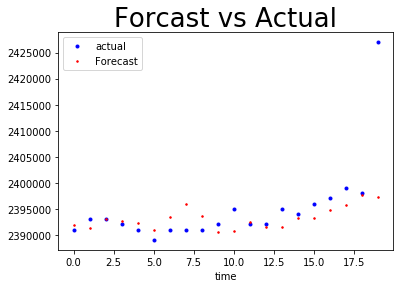

In [16]:

tf.reset_default_graph()
plt.title('Forcast vs Actual', fontsize= 26)
plt.plot(pd.Series(np.ravel(y_test)),'bo',markersize=3,label='actual')
plt.plot(pd.Series(np.ravel(y_pred)), "r.", markersize=3, label="Forecast")
plt.legend(loc='upper left')
plt.xlabel('time')
plt.show()
